El objetivo de este notebook es hacer una implementación rápida de un Decision Tree y ganar intuición sobre la forma de tomar las decisiones.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/repo_tesis/entorno_tesis_Molina"
!source bin/activate

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/repo_tesis/entorno_tesis_Molina


In [ ]:
!pip install comet_ml

In [ ]:
import numpy as np
import joblib
import sys
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from comet_ml import Experiment
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Importar los datos
features = joblib.load("/content/drive/My Drive/repo_tesis/data/FEATURES_W200_I50.joblib")
label = joblib.load("/content/drive/My Drive/repo_tesis/data/label_W200_I50.joblib")

features_array = np.array(features)
label_array = np.array(label)

In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"

folds_ind = joblib.load('folds_W200_I50_sujetoTest_' + str(1) + '.pkl')
sujetos_array = joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(1) + '.pkl')

print(folds_ind)
print(sujetos_array)

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest
[array([   0,    1,    2, ..., 5555, 5556, 5557]), array([ 5558,  5559,  5560, ..., 12118, 12119, 12120]), array([12121, 12122, 12123, ..., 17671, 17672, 17673]), array([17674, 17675, 17676, ..., 24621, 24622, 24623]), array([24624, 24625, 24626, ..., 31115, 31116, 31117]), array([31118, 31119, 31120, ..., 37990, 37991, 37992]), array([37993, 37994, 37995, ..., 44782, 44783, 44784]), array([44785, 44786, 44787, ..., 51319, 51320, 51321]), array([51322, 51323, 51324, ..., 57842, 57843, 57844]), array([57845, 57846, 57847, ..., 64523, 64524, 64525])]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
# armo una lista del largo de los datos, en el que indico a que fold corresponde cada uno
# por el criterio elegido, se que el primer fold es para test, asi que lo saco
fold_test = folds_ind[0]

# ahora lo quito para no armar entrevero
folds_ind = folds_ind[1:]
sujetos_CV = sujetos_array[1:]   # me quedo solo con los sujetos que voy usar para hacer CV


In [ ]:
# ahora tengo los 9 folds que voy a usar en la CV
test_fold = []

# Concatenar y aplanar la lista de arreglos
folds_ind_aplanado = np.concatenate(folds_ind).ravel()

for i in range(len(folds_ind)):
  for j in range(len(folds_ind[i])):
    test_fold.append(i)

# folds_ind_aplanado guarda el indice de dato de cada elemento de test_fold
# lo guardo en un DataFrame para que quede mas claro
data = {
    'indice_dato': folds_ind_aplanado,
    'fold_aux': test_fold
}
# le puse fold_aux porque es para esta iteracion, siempre comienzo desde 0
# segun chatgpt puedo saltearme numeros, y arrancar en otro. eventualmente podria hacerlo asi y solo una vez
# si me interesa identificar mas facil los folds que se usaron para la CV. por ahora creo que no es necesario, por lo que no lo voy a hacer

df_division_folds = pd.DataFrame(data)


In [ ]:
df_division_folds

,indice_dato,fold_aux
0,5558,0
1,5559,0
2,5560,0
3,5561,0
4,5562,0
...,...,...
58963,64521,8
58964,64522,8
58965,64523,8
58966,64524,8


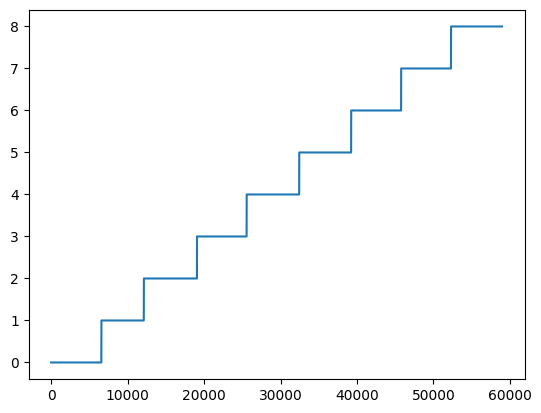

In [ ]:
plt.figure()
plt.plot(test_fold)

In [ ]:
# Crear el objeto PredefinedSplit
ps = PredefinedSplit(test_fold)

# Crear el pipeline con StandardScaler y RandomForestClassifier
full_pipeline = Pipeline([
    ('dt_classifier', DecisionTreeClassifier())
])

# Definir los parámetros para GridSearch
param_grid = {
    'dt_classifier__max_depth': [5, 10, 15, 20],
}

X_cv = features_array[folds_ind_aplanado, :]
y_cv = label_array[folds_ind_aplanado, 1]

# Configurar GridSearchCV con el pipeline y PredefinedSplit
grid_search = GridSearchCV(estimator=full_pipeline, param_grid=param_grid, cv=ps, scoring='accuracy', return_train_score=True)

# Ejecutar GridSearchCV
grid_search.fit(X_cv, y_cv)

# Resultados
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación:", grid_search.best_score_)

GridSearchCV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 8, 8])),
             estimator=Pipeline(steps=[('dt_classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'dt_classifier__max_depth': [5, 10, 15, 20]},
             return_train_score=True, scoring='accuracy')

In [ ]:
joblib.dump(grid_search, "prueba_gridSearch_dt")

['prueba_gridSearch_dt']

In [ ]:
# Obtener los resultados de GridSearchCV
results = grid_search.cv_results_

# Crear un DataFrame con los resultados
df_results = pd.DataFrame(results)

df_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt_classifier__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,mean_train_score,std_train_score
0,10.821761,0.759209,0.005579,0.000948,5,{'dt_classifier__max_depth': 5},0.242724,0.233207,0.270791,0.288112,...,0.311167,0.293994,0.308572,0.324919,0.313688,0.317980,0.310726,0.304818,0.311216,0.008161
1,19.165301,0.578846,0.013174,0.020244,10,{'dt_classifier__max_depth': 10},0.283712,0.280569,0.291799,0.338774,...,0.491061,0.472971,0.494016,0.504828,0.499923,0.500257,0.499990,0.476639,0.492990,0.010440
2,26.004095,0.566351,0.006193,0.001326,15,{'dt_classifier__max_depth': 15},0.283559,0.274086,0.288058,0.280259,...,0.716728,0.686589,0.718318,0.721728,0.710116,0.721367,0.715073,0.690363,0.710554,0.012293
3,29.980268,0.365037,0.006412,0.000835,20,{'dt_classifier__max_depth': 20},0.266342,0.250495,0.291655,0.281183,...,0.903660,0.878600,0.893624,0.902137,0.896044,0.897561,0.899552,0.879492,0.893913,0.008532


In [ ]:
# ESTO ES JUNTANDO TODOS LOS RESULTADOS EN UN DATAFRAME

# Obtener los resultados de GridSearchCV
results = grid_search.cv_results_

# Crear una lista para almacenar los resultados
fold_results = []

# Obtener el número de splits (folds)
n_splits = len([key for key in results.keys() if key.startswith('split') and key.endswith('_test_score')])

# Iterar sobre los resultados para cada combinación de hiperparámetros
for i in range(len(results['params'])):
    for fold in range(n_splits):
        fold_result = {
            'Hyperparameter': results['param_dt_classifier__max_depth'][i],  # Valor del hiperparámetro
            'Fold': fold,  # Número de fold
            'Train Accuracy': results[f'split{fold}_train_score'][i],  # Puntaje de entrenamiento
            'Validation Accuracy': results[f'split{fold}_test_score'][i]  # Puntaje de validación
        }
        fold_results.append(fold_result)

# Crear un DataFrame con los resultados
df_results = pd.DataFrame(fold_results)

df_results

,Hyperparameter,Fold,Train Accuracy,Validation Accuracy
0,5,0,0.315084,0.242724
1,5,1,0.311167,0.233207
2,5,2,0.293994,0.270791
3,5,3,0.308572,0.288112
4,5,4,0.324919,0.178182
5,5,5,0.313688,0.217020
6,5,6,0.317980,0.268472
7,5,7,0.310726,0.223517
8,5,8,0.304818,0.203712
9,10,0,0.497224,0.283712


In [ ]:
# Crear un diccionario para almacenar los DataFrames
hyperparam_results = {}

# Obtener el número de splits (folds)
n_splits = len([key for key in results.keys() if key.startswith('split') and key.endswith('_test_score')])

# Iterar sobre los resultados para cada combinación de hiperparámetros
for i in range(len(results['params'])):
    param_value = results['param_dt_classifier__max_depth'][i]
    fold_results = []
    for fold in range(n_splits):
        fold_result = {
            'Fold': fold,  # Número de fold
            'train_accuracy': results[f'split{fold}_train_score'][i],  # Puntaje de entrenamiento
            'val_accuracy': results[f'split{fold}_test_score'][i]  # Puntaje de validación
        }
        fold_results.append(fold_result)

    # Crear un DataFrame para esta combinación de hiperparámetros
    df_results = pd.DataFrame(fold_results)

    # Añadir el DataFrame al diccionario
    hyperparam_results[f"max_depth={param_value}"] = df_results

# Mostrar los resultados para cada hiperparámetro
for param, df in hyperparam_results.items():
    print(f"Results for {param}:")
    print(df)
    print("\n")

Results for max_depth=5:
   Fold  train_accuracy  val_accuracy
0     0        0.315084      0.242724
1     1        0.311167      0.233207
2     2        0.293994      0.270791
3     3        0.308572      0.288112
4     4        0.324919      0.178182
5     5        0.313688      0.217020
6     6        0.317980      0.268472
7     7        0.310726      0.223517
8     8        0.304818      0.203712


Results for max_depth=10:
   Fold  train_accuracy  val_accuracy
0     0        0.497224      0.283712
1     1        0.491061      0.280569
2     2        0.472971      0.291799
3     3        0.494016      0.338774
4     4        0.504828      0.164800
5     5        0.499923      0.228062
6     6        0.500257      0.266330
7     7        0.499990      0.270888
8     8        0.476639      0.229606


Results for max_depth=15:
   Fold  train_accuracy  val_accuracy
0     0        0.714703      0.283559
1     1        0.716728      0.274086
2     2        0.686589      0.288058
3     3

In [ ]:
hyperparam_results['max_depth=10']

,Fold,train_accuracy,val_accuracy
0,0,0.497224,0.283712
1,1,0.491061,0.280569
2,2,0.472971,0.291799
3,3,0.494016,0.338774
4,4,0.504828,0.164800
5,5,0.499923,0.228062
6,6,0.500257,0.266330
7,7,0.499990,0.270888
8,8,0.476639,0.229606


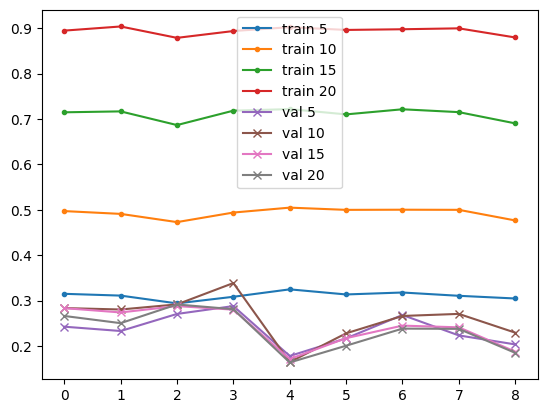

In [ ]:
# Armo una grafica similar a la que tenia antes
plt.figure()
plt.plot(hyperparam_results['max_depth=5'].train_accuracy, '.-')
plt.plot(hyperparam_results['max_depth=10'].train_accuracy, '.-')
plt.plot(hyperparam_results['max_depth=15'].train_accuracy, '.-')
plt.plot(hyperparam_results['max_depth=20'].train_accuracy, '.-')

plt.plot(hyperparam_results['max_depth=5'].val_accuracy, '-x')
plt.plot(hyperparam_results['max_depth=10'].val_accuracy, '-x')
plt.plot(hyperparam_results['max_depth=15'].val_accuracy, '-x')
plt.plot(hyperparam_results['max_depth=20'].val_accuracy, '-x')

plt.legend(['train 5', 'train 10', 'train 15', 'train 20','val 5', 'val 10', 'val 15', 'val 20'])

In [ ]:
# Crear un diccionario para almacenar los DataFrames
hyperparam_results = {}

# Obtener el número de splits (folds)
n_splits = len([key for key in results.keys() if key.startswith('split') and key.endswith('_test_score')])

# Iterar sobre los resultados para cada combinación de hiperparámetros
for i in range(len(results['params'])):
    param_value = results['params'][i]  # Obtener la combinación de hiperparámetros
    fold_results = []
    for fold in range(n_splits):
        fold_result = {
            'Fold': fold,  # Número de fold
            'train_accuracy': results[f'split{fold}_train_score'][i],  # Puntaje de entrenamiento
            'val_accuracy': results[f'split{fold}_test_score'][i],  # Puntaje de validación
            'Hyperparameters': str(param_value)  # Combinación de hiperparámetros como cadena de texto
        }
        fold_results.append(fold_result)

    # Crear un DataFrame para esta combinación de hiperparámetros
    df_results = pd.DataFrame(fold_results)

    # Añadir el DataFrame al diccionario
    hyperparam_results[f"params_{i}"] = df_results


In [ ]:
print(hyperparam_results)

{'params_0':    Fold  Train Accuracy  Validation Accuracy                  Hyperparameters
0     0        0.315084             0.242724  {'dt_classifier__max_depth': 5}
1     1        0.311167             0.233207  {'dt_classifier__max_depth': 5}
2     2        0.293994             0.270791  {'dt_classifier__max_depth': 5}
3     3        0.308572             0.288112  {'dt_classifier__max_depth': 5}
4     4        0.324919             0.178182  {'dt_classifier__max_depth': 5}
5     5        0.313688             0.217020  {'dt_classifier__max_depth': 5}
6     6        0.317980             0.268472  {'dt_classifier__max_depth': 5}
7     7        0.310726             0.223517  {'dt_classifier__max_depth': 5}
8     8        0.304818             0.203712  {'dt_classifier__max_depth': 5}, 'params_1':    Fold  Train Accuracy  Validation Accuracy                   Hyperparameters
0     0        0.497224             0.283712  {'dt_classifier__max_depth': 10}
1     1        0.491061             

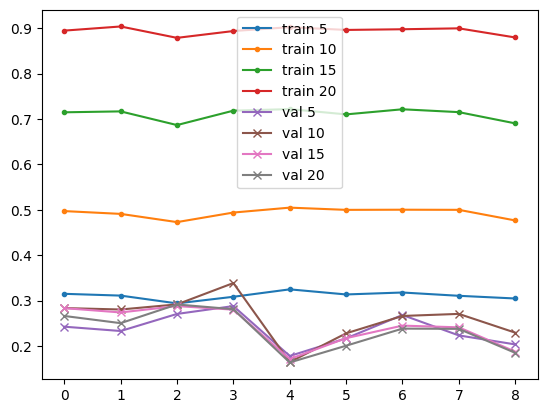

In [ ]:
# Armo una grafica similar a la que tenia antes
plt.figure()
plt.plot(hyperparam_results['params_0'].train_accuracy, '.-')
plt.plot(hyperparam_results['params_1'].train_accuracy, '.-')
plt.plot(hyperparam_results['params_2'].train_accuracy, '.-')
plt.plot(hyperparam_results['params_3'].train_accuracy, '.-')

plt.plot(hyperparam_results['params_0'].val_accuracy, '-x')
plt.plot(hyperparam_results['params_1'].val_accuracy, '-x')
plt.plot(hyperparam_results['params_2'].val_accuracy, '-x')
plt.plot(hyperparam_results['params_3'].val_accuracy, '-x')

plt.legend(['train 5', 'train 10', 'train 15', 'train 20','val 5', 'val 10', 'val 15', 'val 20'])

In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"

i = 0
folds_ind = joblib.load('folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl') # lista de listas. en cada elemento tengo la lista de indices de un fold
sujetos_array = joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl')   # lista con todos los sujetos, donde el primero corresponde al de test

# por el criterio elegido, se que el primer fold es para test, asi que lo saco
fold_test = folds_ind[0]

# ahora lo quito para no armar entrevero
folds_ind = folds_ind[1:]
sujetos_CV = sujetos_array[1:]   # me quedo solo con los sujetos que voy usar para hacer CV

fold_ind_val = folds_ind[0]    # separo un fold para validar
folds_ind = folds_ind[1:]       # quito el fold que voy a usar para validar de los de train

# paso la informacion de indices a array
fold_ind_val_array = np.array(fold_ind_val)
# concateno los arrays de train_ind en uno solo
folds_ind_train_array = np.concatenate(folds_ind)
# aplanar el array resultante
folds_ind_train_array = folds_ind_train_array.ravel()

# Defino X_train, y_train, X_val, y_val
X_train = features_array[folds_ind_train_array, :]
y_train = label_array[folds_ind_train_array, 1]

X_val = features_array[fold_ind_val_array, :]
y_val = label_array[fold_ind_val_array, 1]

clf = ExtraTreesClassifier(n_estimators=500, max_depth=30, random_state=42)

# Entrenar el clasificador
clf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = clf.predict(X_val)

# Calcular la precisión
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)


/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest
Accuracy: 0.37879018741429227


In [ ]:
clf1 = RandomForestClassifier(n_estimators=500, max_depth=15, random_state=42)

# Entrenar el clasificador
clf1.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = clf1.predict(X_val)

# Calcular la precisión
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.37162882827975013


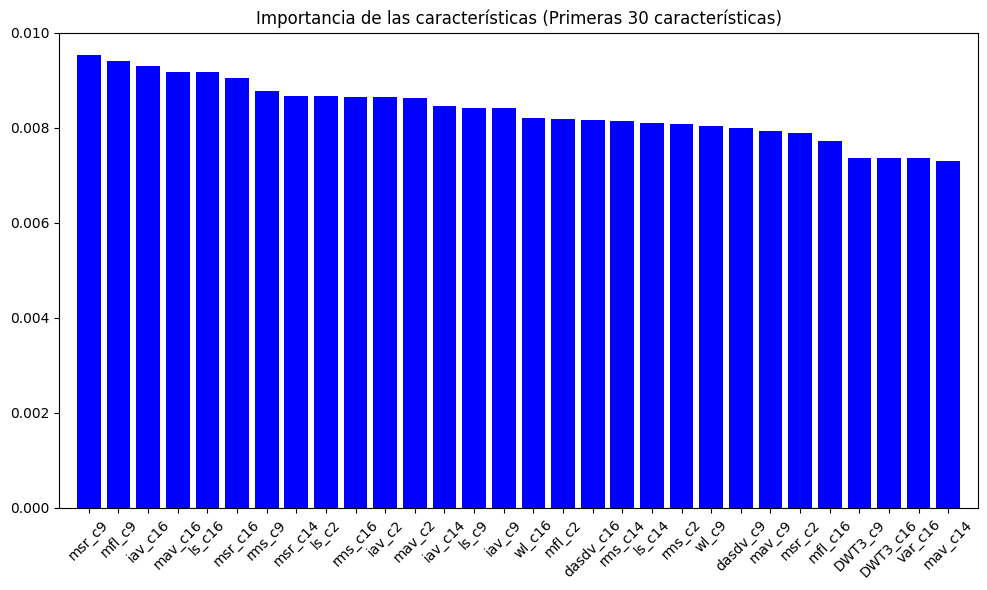

In [ ]:

# Número de características a mostrar
top_n = 30

# Obtener la importancia de las características
importances = clf.feature_importances_

# Obtener los nombres de las características desde el DataFrame
feature_names = features.columns

# Ordenar los índices de importancia en orden descendente
indices = importances.argsort()[::-1]

# Tomar solo las primeras N características más importantes
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_feature_names = [feature_names[i] for i in top_indices]

# Graficar
plt.figure(figsize=(10, 6))
plt.title("Importancia de las características (Primeras {} características)".format(top_n))
plt.bar(range(len(top_feature_names)), top_importances, color="b", align="center")
plt.xticks(range(len(top_feature_names)), top_feature_names, rotation=45)
plt.xlim([-1, len(top_feature_names)])
plt.tight_layout()
plt.show()


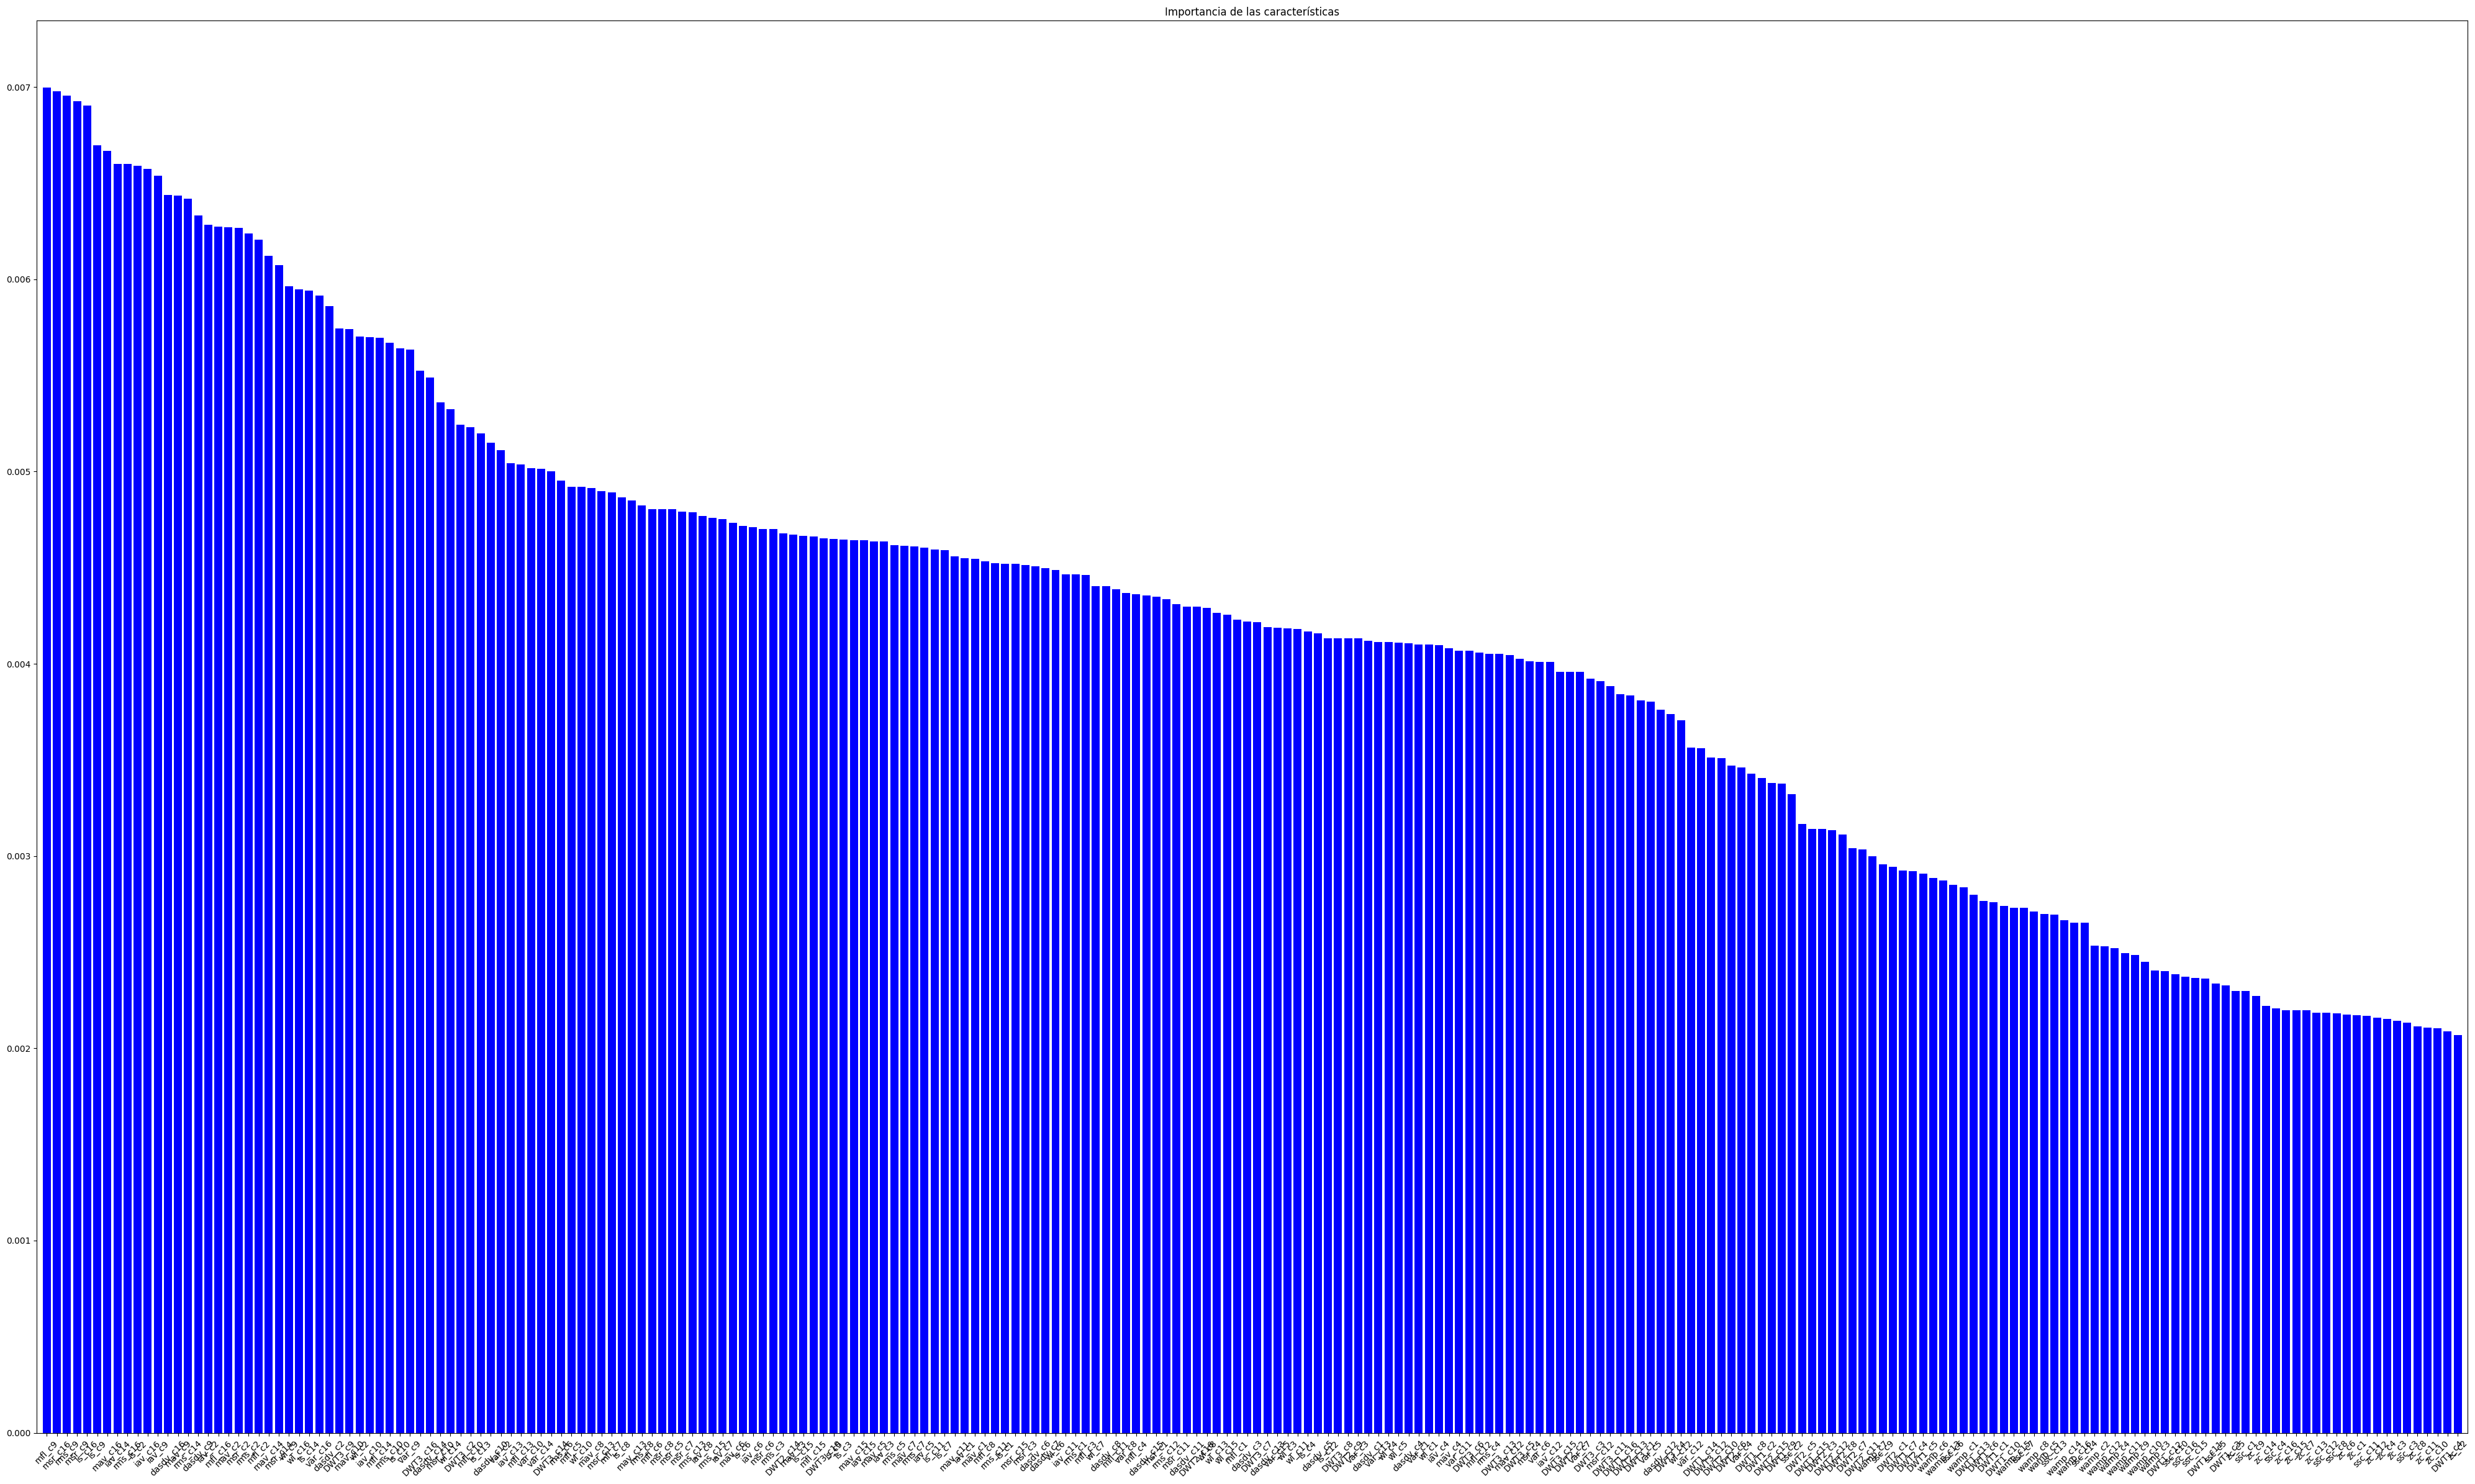

<Figure size 640x480 with 0 Axes>

In [ ]:
# Obtener la importancia de las características
importances = clf.feature_importances_

# Obtener los nombres de las características desde el DataFrame
feature_names = features.columns

# Ordenar los índices de importancia en orden descendente
indices = importances.argsort()[::-1]

# Graficar
plt.figure(figsize=(40, 24))
plt.title("Importancia de las características")
plt.bar(range(len(feature_names)), importances[indices], color="b", align="center")
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45)
plt.xlim([-1, len(feature_names)])
plt.tight_layout()
plt.show()

plt.savefig("importancia_caracteristicas.pdf")

In [ ]:
k = 1   # sujeto de test
nombre = 'HW_NP_DecisionTree_sep_sub_CV_' + str(k) + '_test'

joblib.dump(modelos_grilla, nombre + '.pkl')

API_KEY = 'ehXeElNypcj7Knar5zTmyjwSO'

exp = Experiment(api_key=API_KEY,
                project_name='tesis-experimentos', # Nombre del proyecto donde se registran los experimentos
                auto_param_logging=False)
exp.set_name(nombre) # Nombre de este experimento
exp.add_tags(['HelloWorld', 'DecisionTree', 'sep_sub', 'choose_test', 'gridSearch']) # Tags

exp.log_asset("metricas_CV", data)

exp.log_parameter("particion_sujetos", sujetos_array)   # Guarda el arreglo en el experimento
exp.log_parameter("param_grid", grilla_max_depth)   # Guarda el arreglo en el experimento
exp.log_text("Se fija el sujeto de test. Se hace una búsqueda del parámetro max_depth. El primer sujeto del arreglo de sujetos es el de test.")   # Comentario del experimento
exp.log_model(name=nombre, file_or_folder=nombre + '.pkl')
exp.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : HW_NP_DecisionTree_sep_sub_CV_1_test
COMET INFO:     url                   : https://www.comet.com/manuelmolinach99/tesis-experimentos/820c8ac79bf2465899ea50acbe54f804
COMET INFO:   Others:
COMET INFO:     Name : HW_NP_DecisionTree_sep_sub_CV_1_test
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (775.80 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                

In [ ]:
# Convertir cada DataFrame en cada lista interna a una lista de listas
data = []
for lista_df in metricas_grilla:
    data.append([df.values.tolist() for df in lista_df])